In [1]:
import os
import json
import argparse
import pprint as pp
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from datetime import timedelta

import networkx as nx
from scipy.spatial.distance import pdist, squareform
import torch
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from problems.tsp.problem_tsp import TSP
from utils import load_model, move_to
from train import set_decode_type

import sys
import math
import random
import itertools
from collections import OrderedDict
from gurobipy import *

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

In [3]:
class opts:
    dataset_path = "data/tsp/tsp10-200_concorde.txt"
    batch_size = 16
    accumulation_steps = 80
    num_samples = 25600 # 1280 samples per TSP size 
    
    neighbors = 0.20
    knn_strat = 'percentage'
    
    # model = "outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max_20200313T002243"
    model = "outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931"
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

In [4]:
model, model_args = load_model(opts.model, extra_logging=True)
model.to(opts.device)
set_decode_type(model, "greedy")
model.eval()


Loading model from outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931/epoch-9.pt


AttentionModel(
  (init_embed): Linear(in_features=2, out_features=128, bias=True)
  (embedder): GNNEncoder(
    (init_embed_edges): Embedding(2, 128)
    (layers): ModuleList(
      (0): GNNLayer(
        (U): Linear(in_features=128, out_features=128, bias=True)
        (V): Linear(in_features=128, out_features=128, bias=True)
        (A): Linear(in_features=128, out_features=128, bias=True)
        (B): Linear(in_features=128, out_features=128, bias=True)
        (C): Linear(in_features=128, out_features=128, bias=True)
        (norm_h): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (norm_e): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (1): GNNLayer(
        (U): Linear(in_features=128, out_features=128, bias=True)
        (V): Linear(in_features=128, out_features=128, bias=True)
        (A): Linear(in_features=128, out_features=128, bias=True)
        (B): Linear(in_features=128, out_feat

In [5]:
dataset = TSP.make_dataset(
    filename=opts.dataset_path, batch_size=opts.batch_size, num_samples=opts.num_samples, 
    neighbors=opts.neighbors, knn_strat=opts.knn_strat, supervised=True
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=False, num_workers=0)

  0%|          | 0/25600 [00:00<?, ?it/s]


Loading from data/tsp/tsp10-200_concorde.txt...


100%|##########| 25600/25600 [00:04<00:00, 5152.90it/s]


In [83]:
def plot_tsp(p, x_coord, tour, title="default"):
    """
    Helper function to plot TSP tours.
    
    Args:
        p: Matplotlib figure/subplot
        x_coord: Coordinates of nodes
        tour: Predicted tour
        title: Title of figure/subplot
    
    Returns:
        p: Updated figure/subplot
    """
    W_val = squareform(pdist(x_coord, metric='euclidean'))
    G = nx.from_numpy_matrix(W_val)
    
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    
    tour_pairs = []
    for idx in range(len(tour)-1):
        tour_pairs.append((tour[idx], tour[idx+1]))
    tour_pairs.append((tour[idx+1], tour[0]))
    
    nx.draw_networkx_nodes(G, pos, node_color='b', node_size=30)
    nx.draw_networkx_edges(G, pos, edgelist=tour_pairs, edge_color='black', alpha=1, width=1)
    p.set_title(title)
    return p


def plot_tsp_heatmap(p, x_coord, W_pred, threshold=0.1, title="default"):
    """
    Helper function to plot predicted TSP tours with edge strength denoting confidence of prediction.
    
    Args:
        p: Matplotlib figure/subplot
        x_coord: Coordinates of nodes
        W_pred: Edge predictions matrix
        threshold: Threshold above which edge predicion probabilities are plotted
        title: Title of figure/subplot
    
    Returns:
        p: Updated figure/subplot
    """
    W_val = squareform(pdist(x_coord, metric='euclidean'))
    G = nx.from_numpy_matrix(W_val)
    
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))    
    
    edge_pairs = []
    edge_color = []
    for r in range(len(W_pred)):
        for c in range(len(W_pred)):
            if W_pred[r][c] >= threshold:
                edge_pairs.append((r, c))
                edge_color.append(W_pred[r][c])
    
    nx.draw_networkx_nodes(G, pos, node_color='b', node_size=30)
    nx.draw_networkx_edges(G, pos, edgelist=edge_pairs, edge_color=edge_color, edge_cmap=plt.cm.Reds, width=1)
    p.set_title(title)
    return p


def plot_tsp_rcs(p, x_coord, rcs, threshold=0.5, title="default"):
    """
    Helper function to plot predicted TSP tours with edge strength denoting confidence of prediction.
    
    Args:
        p: Matplotlib figure/subplot
        x_coord: Coordinates of nodes
        rcs: Reduce costs of edges
        threshold: Threshold below which edge reduce costs are plotted
        title: Title of figure/subplot
    
    Returns:
        p: Updated figure/subplot
    """
    W_val = squareform(pdist(x_coord, metric='euclidean'))
    G = nx.from_numpy_matrix(W_val)
    
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))    
    
    edge_pairs = []
    edge_color = []
    for r in range(len(rcs)):
        for c in range(len(rcs)):
            if rcs[r][c] <= threshold:
                edge_pairs.append((r, c))
                edge_color.append(1 - rcs[r][c])
    
    nx.draw_networkx_nodes(G, pos, node_color='b', node_size=30)
    nx.draw_networkx_edges(G, pos, edgelist=edge_pairs, edge_color=edge_color, edge_cmap=plt.cm.Reds, width=1)
    p.set_title(title)
    return p

In [84]:
def subtourelim(model, where):
    # Callback - use lazy constraints to eliminate sub-tours
    
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        selected = tuplelist((i,j) for i,j in model._vars.keys() if vals[i,j] > 0.5)
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        if len(tour) < n:
            # add subtour elimination constraint for every pair of cities in tour
            model.cbLazy(quicksum(model._vars[i,j]
                                  for i,j in itertools.combinations(tour, 2))
                         <= len(tour)-1)

            
def subtour(edges):
    # Given a tuplelist of edges, find the shortest subtour
    
    unvisited = list(range(n))
    cycle = range(n+1) # initial length has 1 more city
    while unvisited: # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i,j in edges.select(current,'*') if j in unvisited]
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle


def get_reduce_costs(points):
    n = len(points)
    
    dist = {
        (i,j) : math.sqrt(sum((points[i][k] - points[j][k])**2 for k in range(2)))
            for i in range(n) for j in range(i)
    }

    m = Model()
    m.setParam('OutputFlag', 0)

    # Create variables
    vars = m.addVars(dist.keys(), obj=dist, vtype=GRB.CONTINUOUS, name='e')
    for i,j in vars.keys():
        vars[j,i] = vars[i,j] # edge in opposite direction

    # Add degree-2 constraint
    m.addConstrs(vars.sum(i,'*') == 2 for i in range(n))

    # Optimize model
    m._vars = vars
    m.Params.lazyConstraints = 1
    m.optimize(subtourelim)

    reduce_costs = np.zeros((len(points), len(points)))
    
    for i, j in dist.keys():
        reduce_costs[i][j] = vars[i,j].RC
        reduce_costs[j][i] = vars[i,j].RC
    
    return reduce_costs

In [85]:
def log_p_to_heatmap(log_p, pi):
    heatmap = np.zeros(log_p.shape)
    heatmap[pi[-1]] = log_p[0]
    for cur_node, next_pred in zip(pi[:-1], log_p[1:]):
        heatmap[cur_node] = next_pred
    return heatmap

def normalize_dists(dists):
    # return dists / dists.max(1, keepdims=True)
    return dists / dists.max()

--------------------------------------------------------------------------------------------------------------------------------------------

TSP10



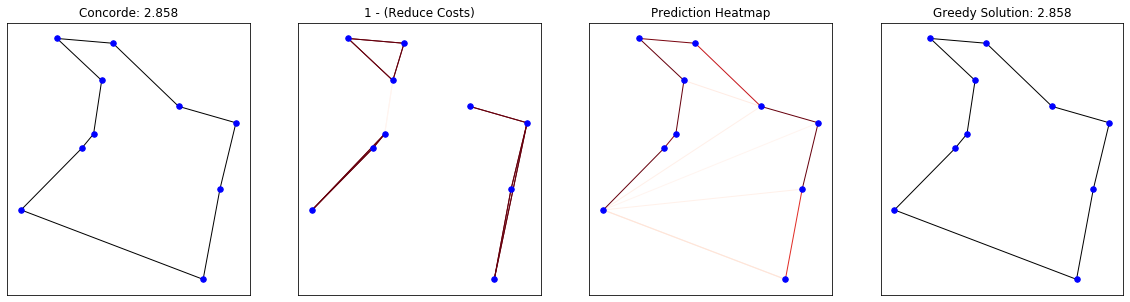

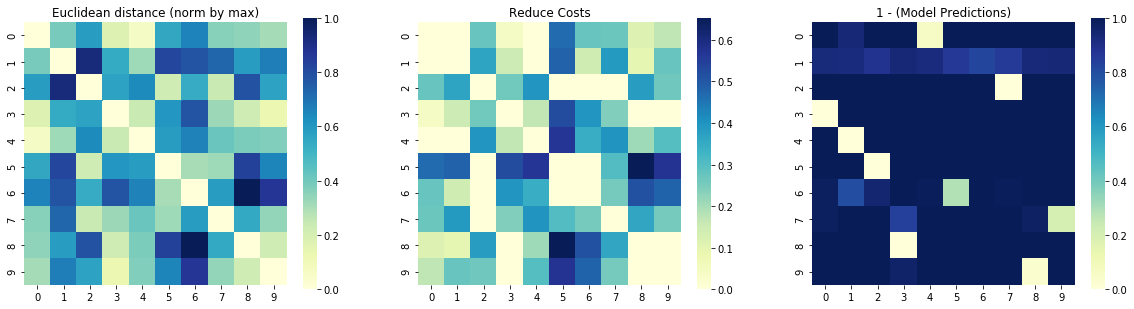

--------------------------------------------------------------------------------------------------------------------------------------------

TSP20



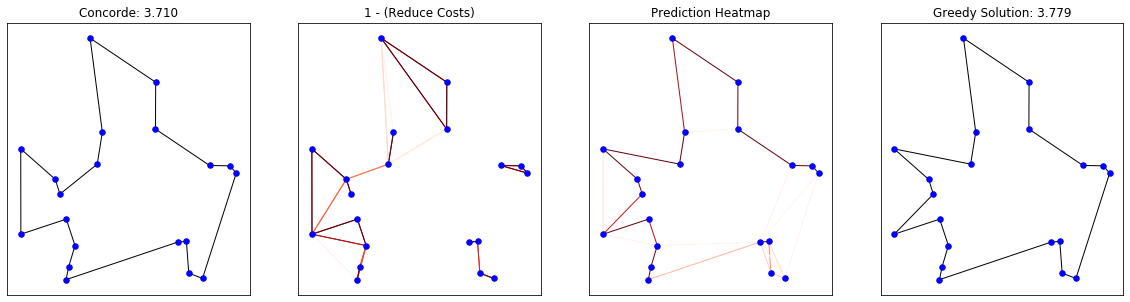

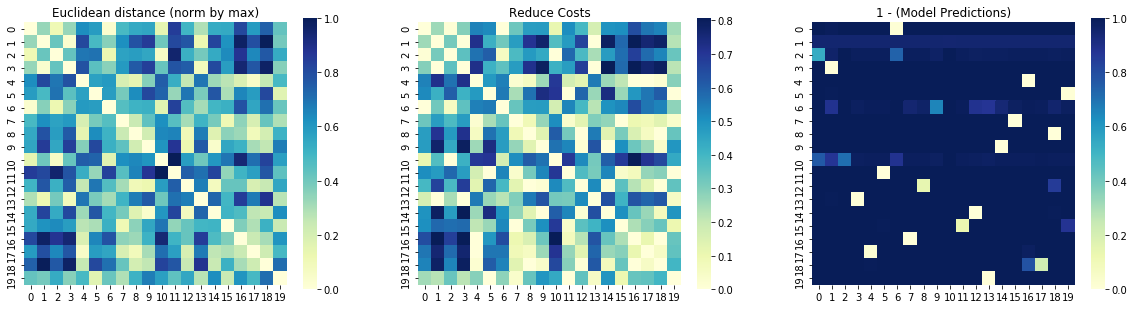

--------------------------------------------------------------------------------------------------------------------------------------------

TSP30



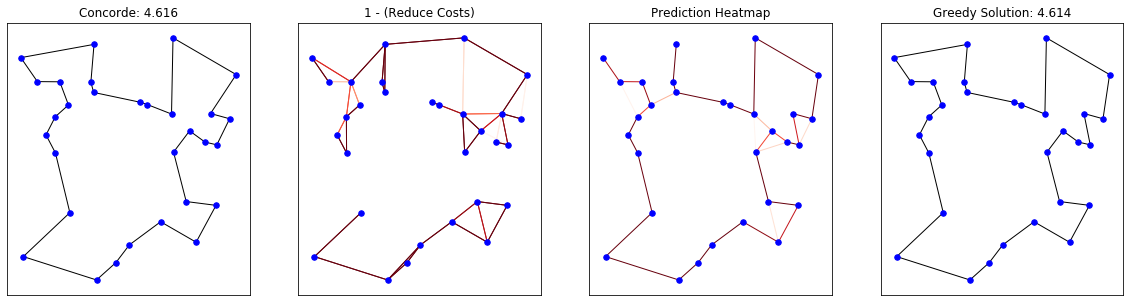

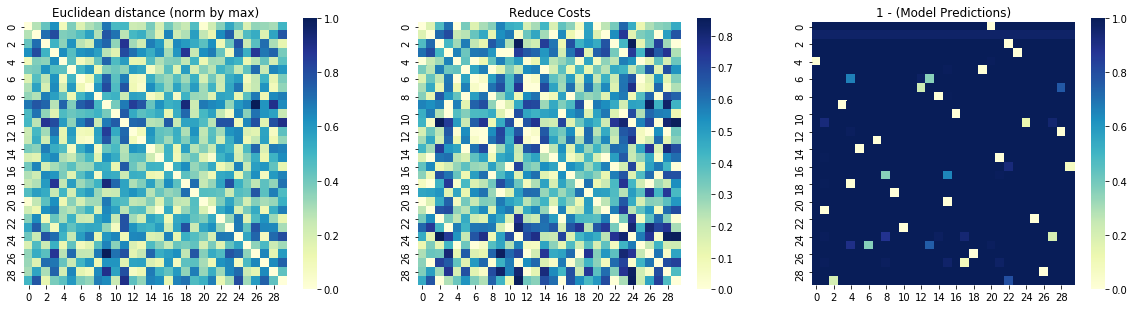

--------------------------------------------------------------------------------------------------------------------------------------------

TSP40



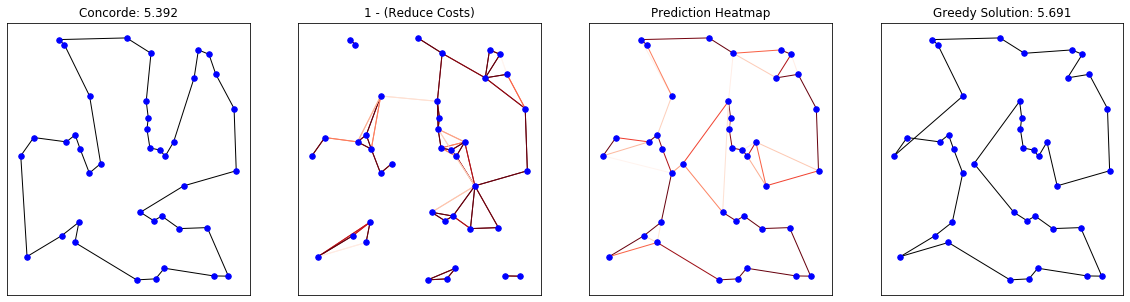

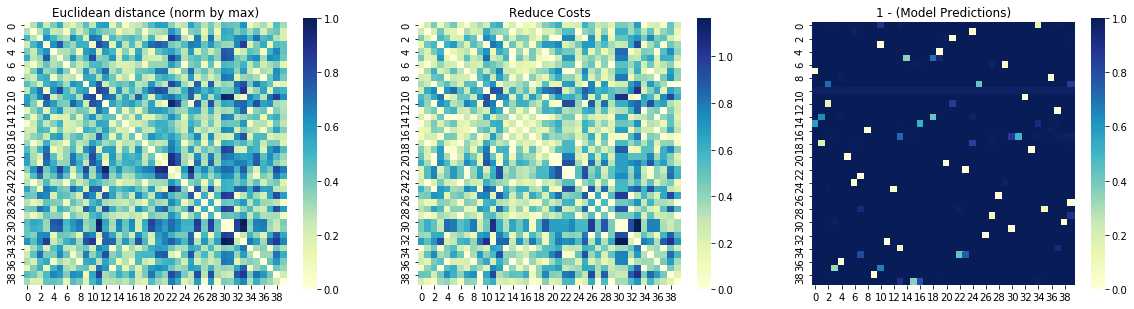

--------------------------------------------------------------------------------------------------------------------------------------------

TSP50



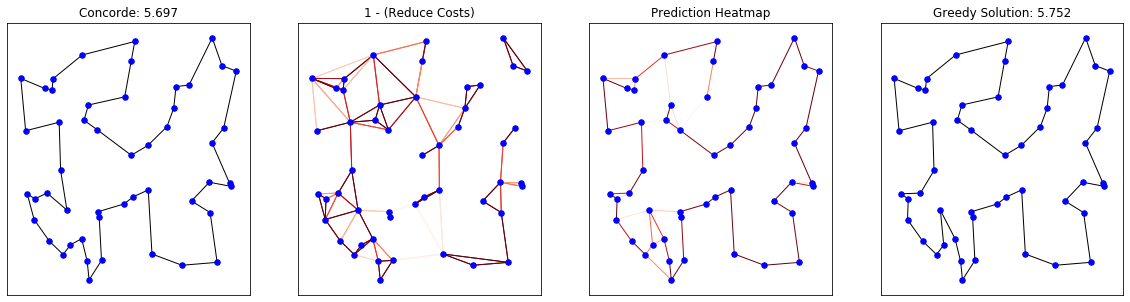

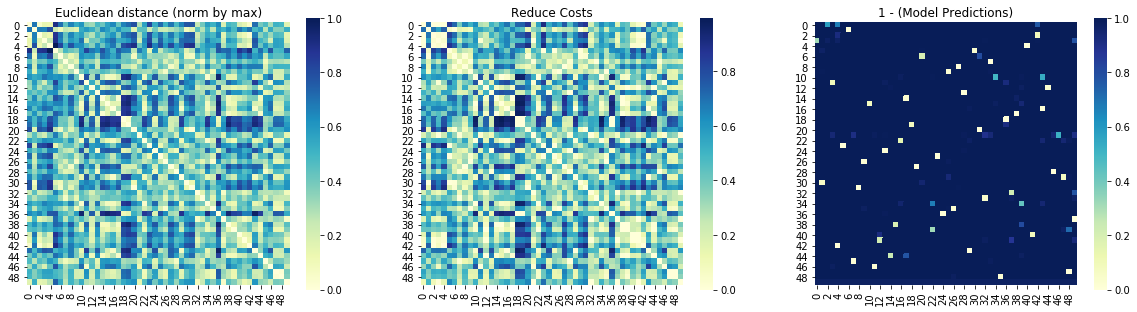

--------------------------------------------------------------------------------------------------------------------------------------------

TSP60



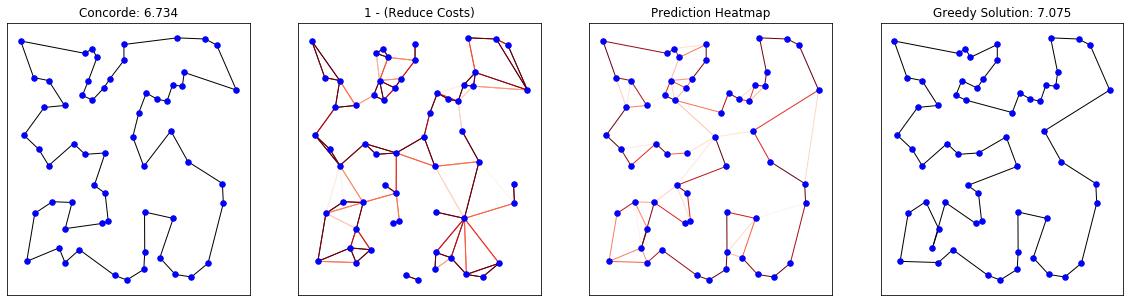

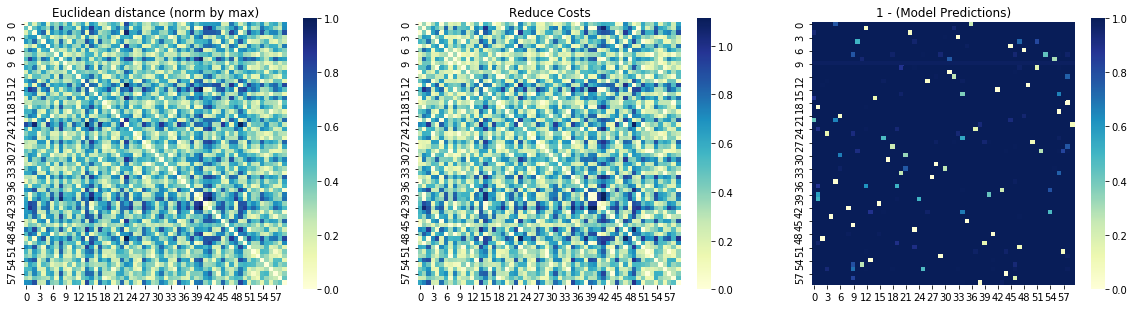

--------------------------------------------------------------------------------------------------------------------------------------------

TSP70



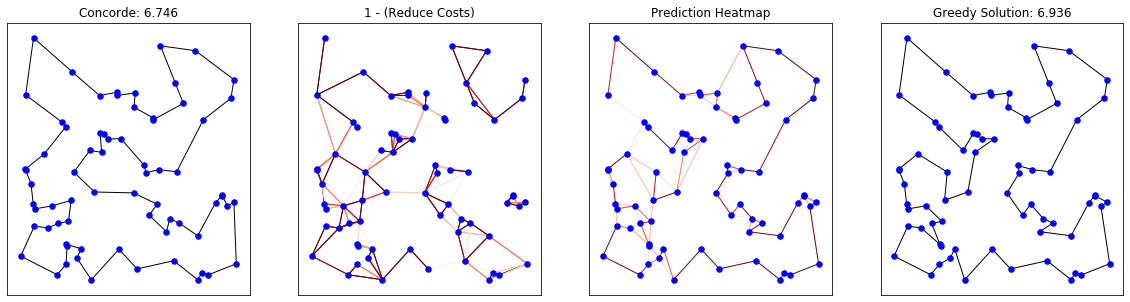

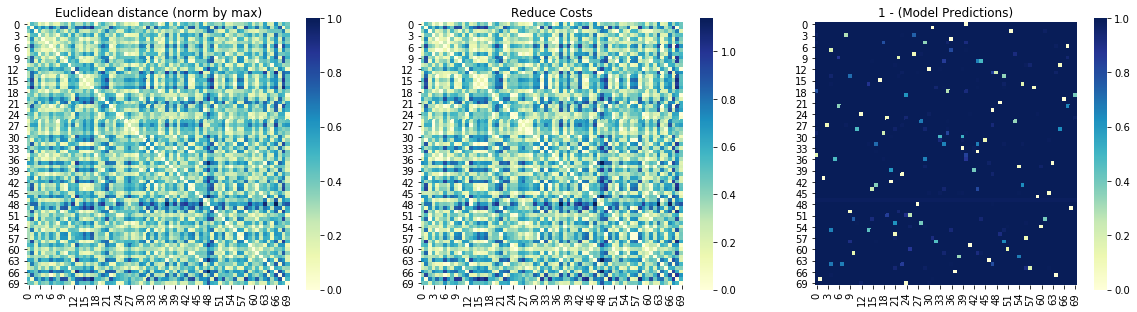

--------------------------------------------------------------------------------------------------------------------------------------------

TSP80



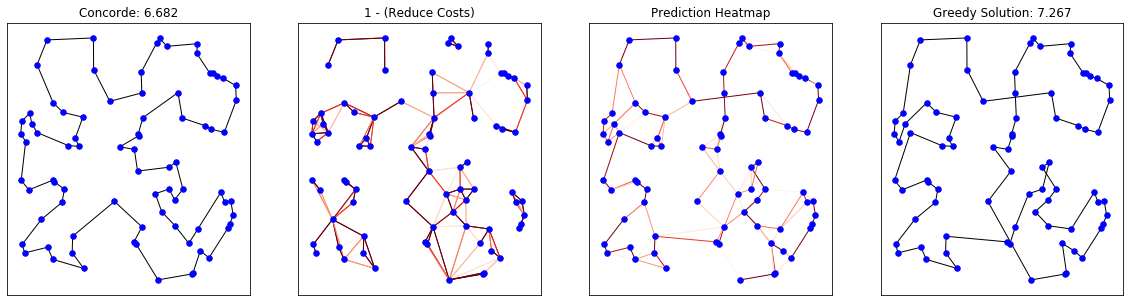

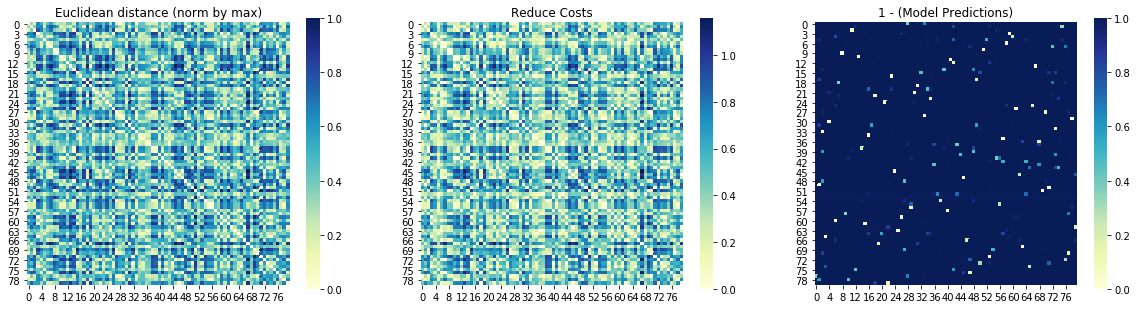

--------------------------------------------------------------------------------------------------------------------------------------------

TSP90



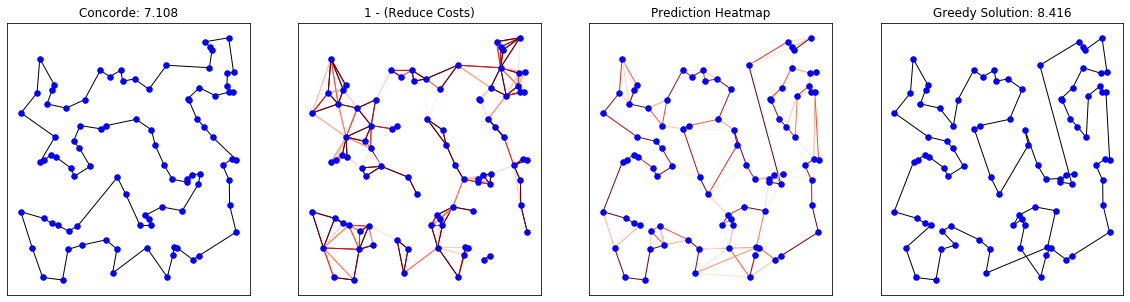

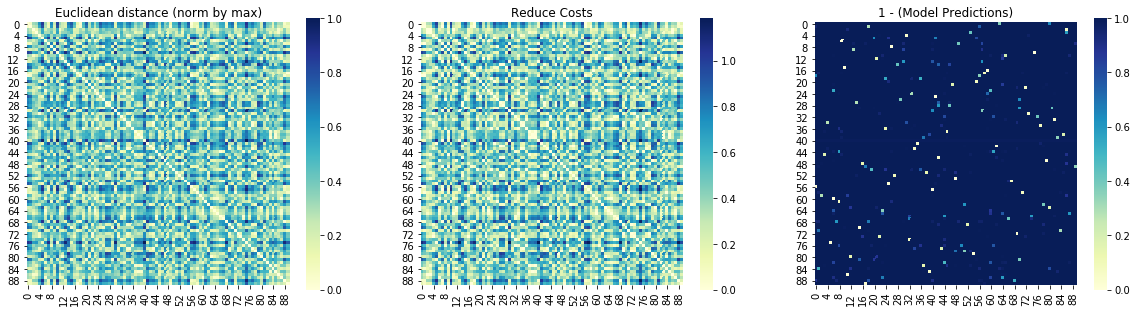

--------------------------------------------------------------------------------------------------------------------------------------------

TSP100



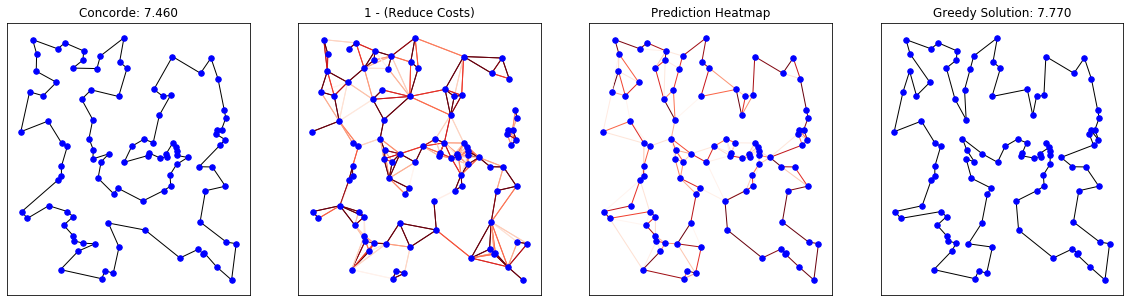

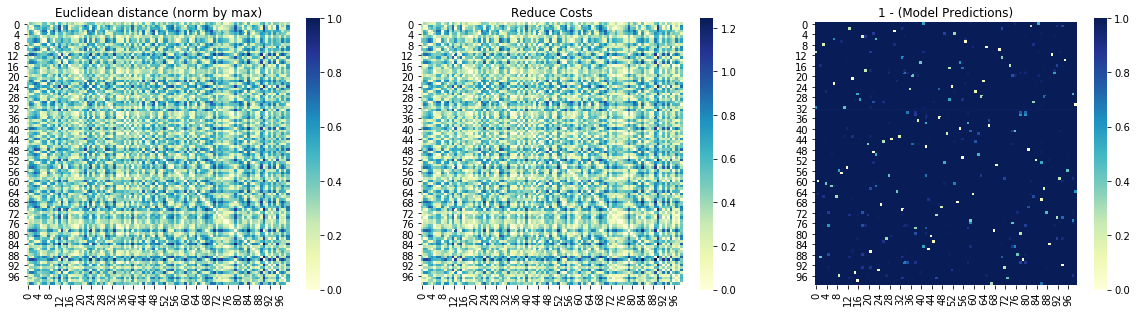

--------------------------------------------------------------------------------------------------------------------------------------------

TSP110



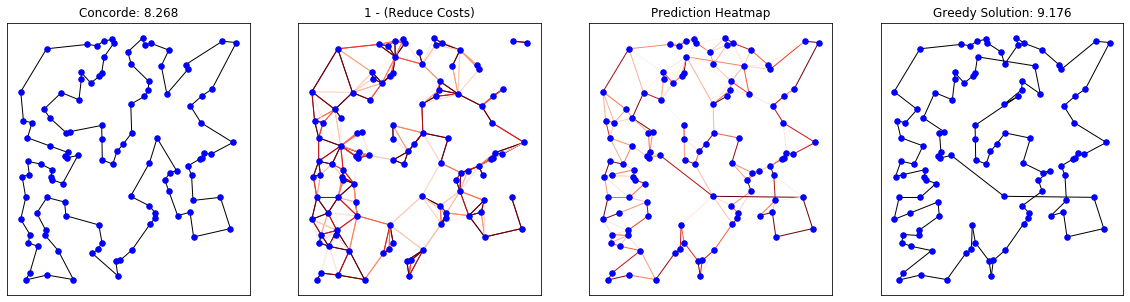

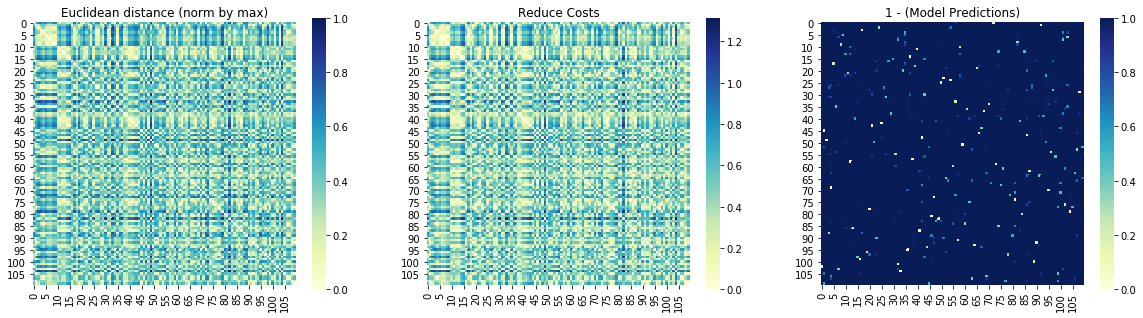

--------------------------------------------------------------------------------------------------------------------------------------------

TSP120



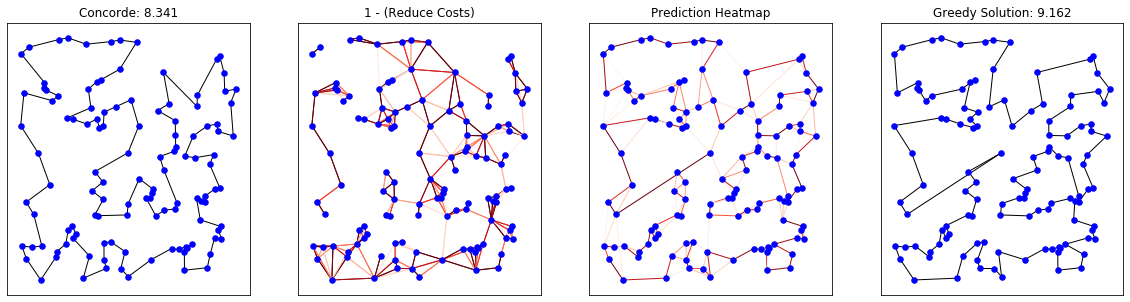

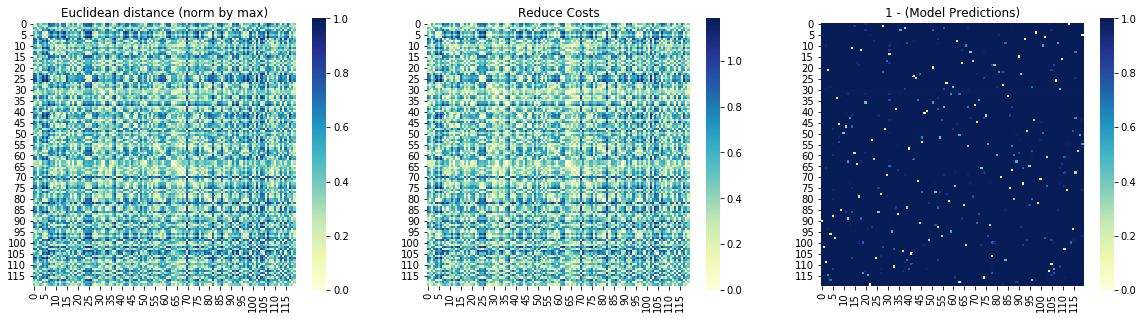

--------------------------------------------------------------------------------------------------------------------------------------------

TSP130



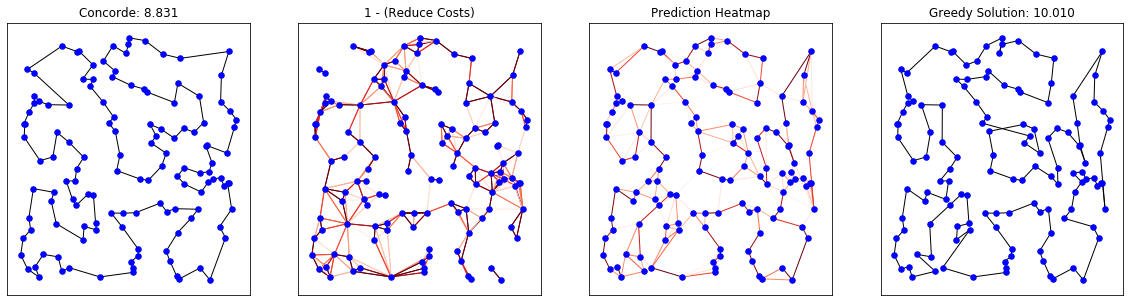

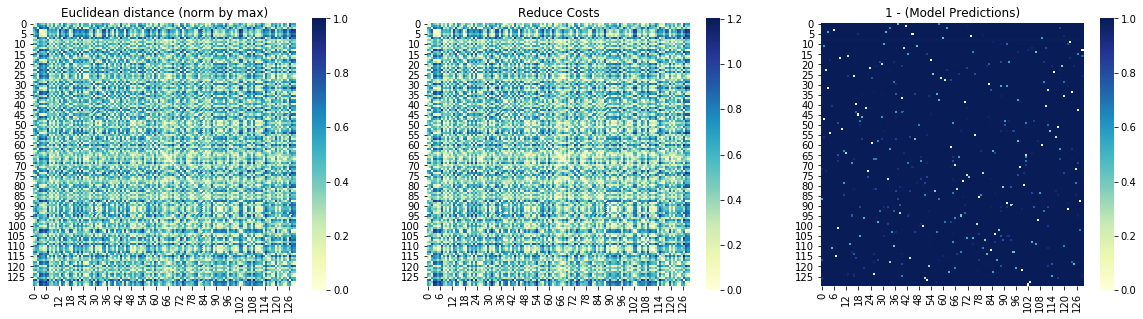

--------------------------------------------------------------------------------------------------------------------------------------------

TSP140



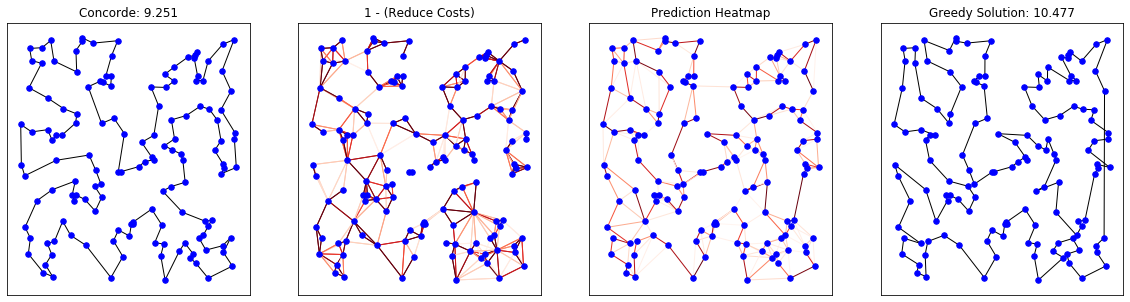

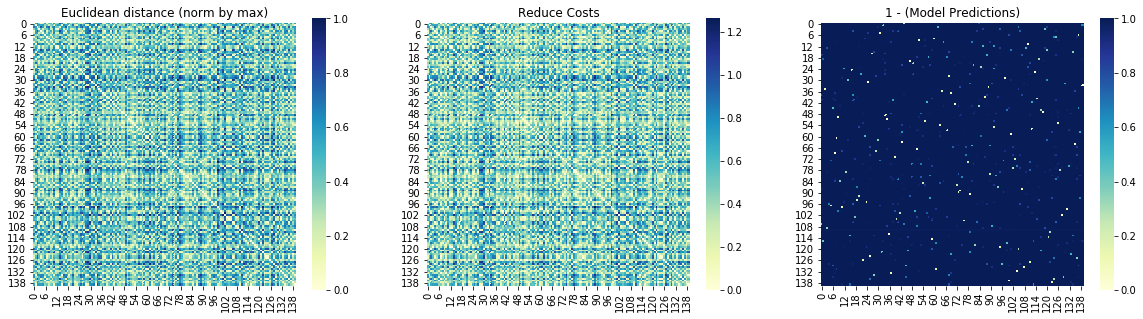

--------------------------------------------------------------------------------------------------------------------------------------------

TSP150



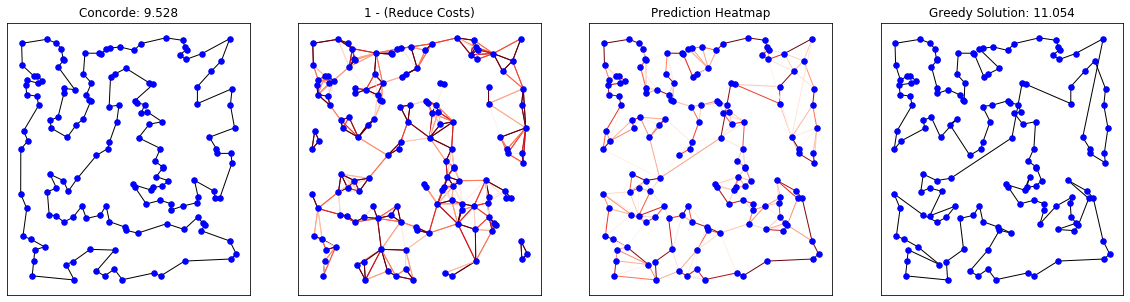

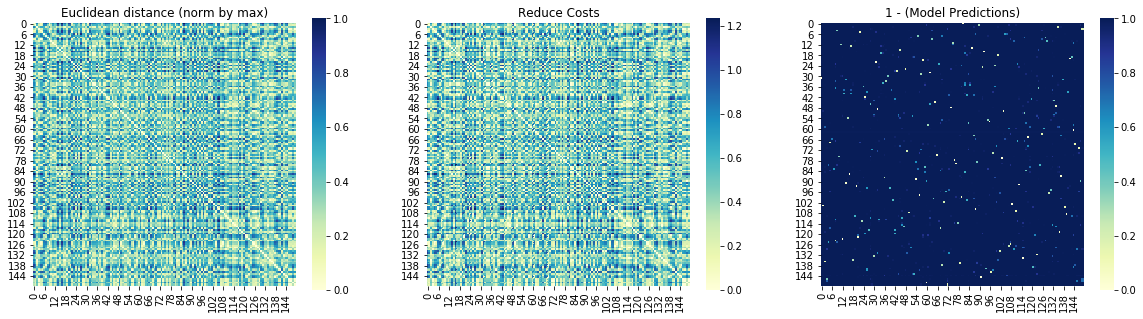

--------------------------------------------------------------------------------------------------------------------------------------------

TSP160



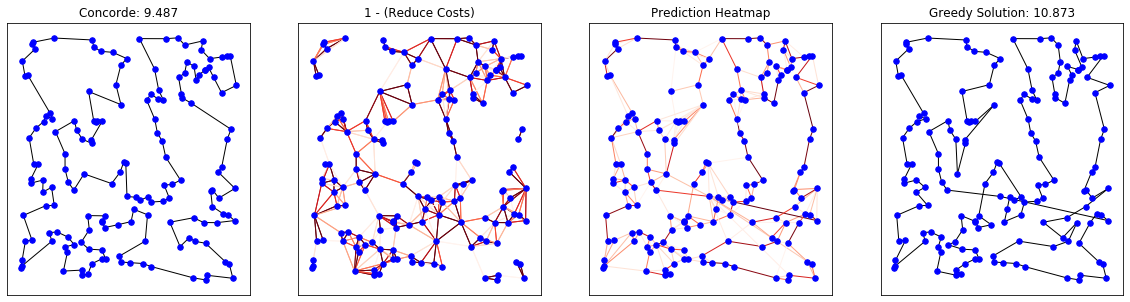

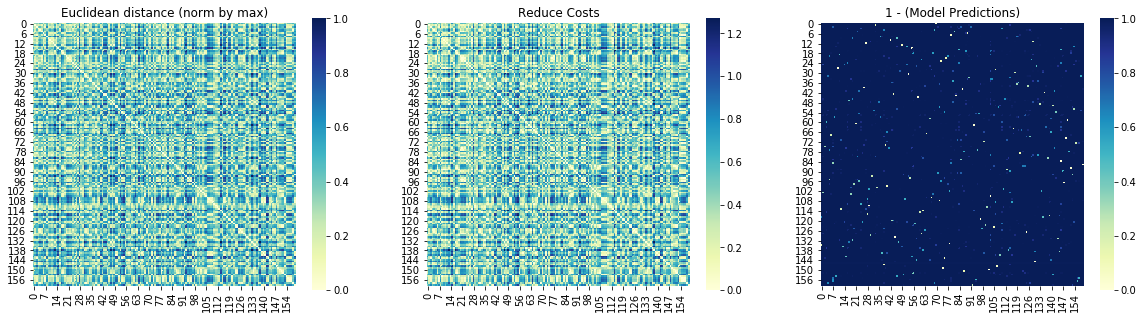

--------------------------------------------------------------------------------------------------------------------------------------------

TSP170



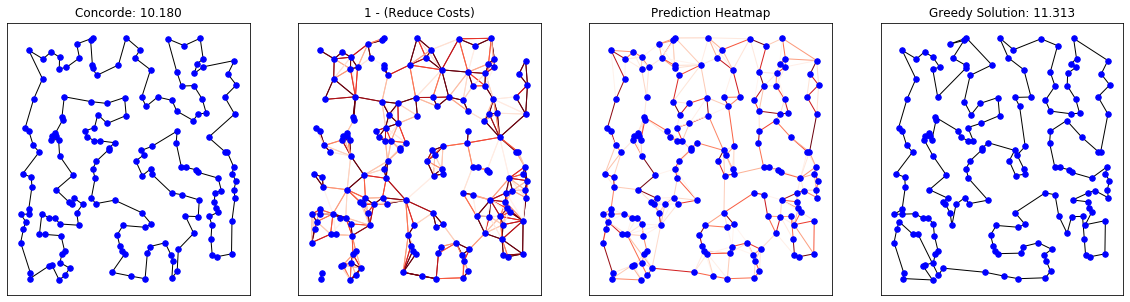

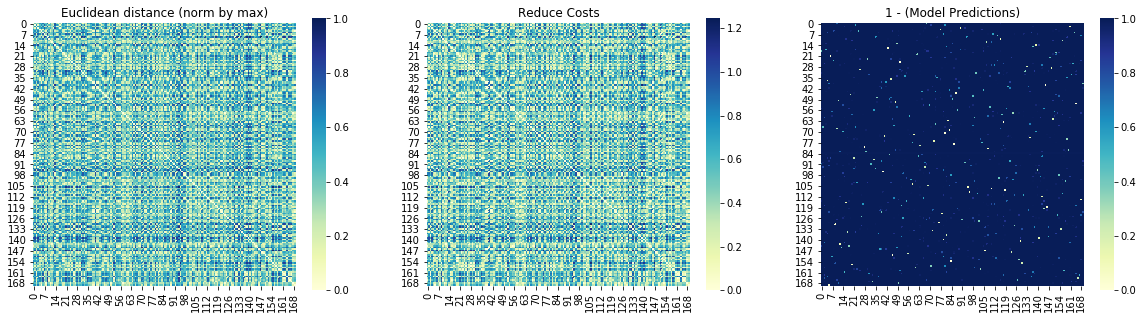

--------------------------------------------------------------------------------------------------------------------------------------------

TSP180



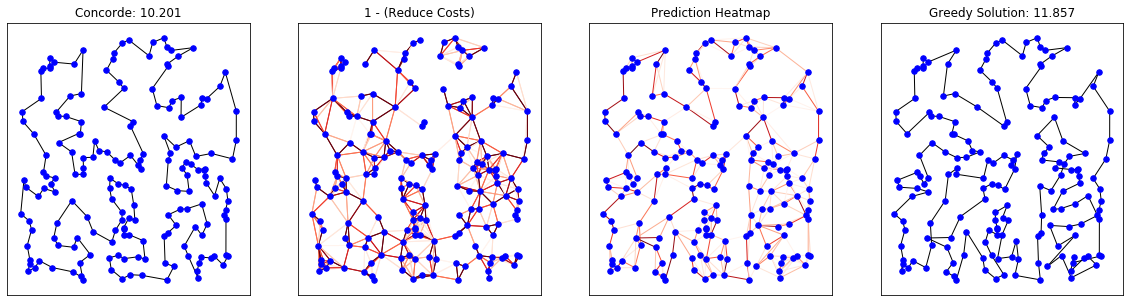

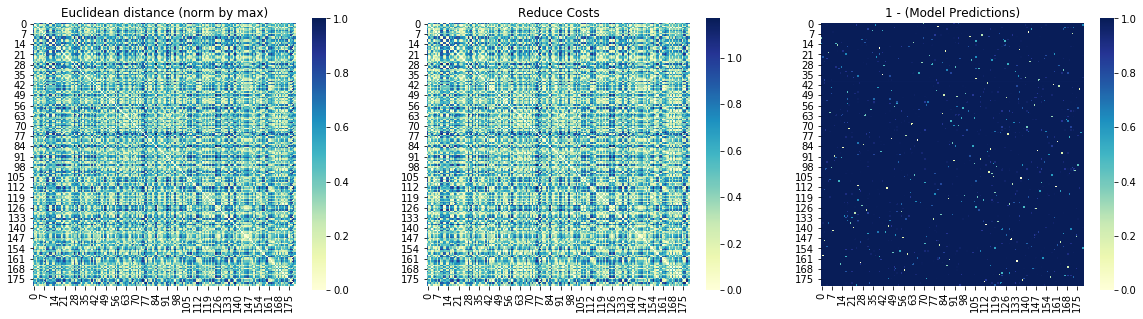

--------------------------------------------------------------------------------------------------------------------------------------------

TSP190



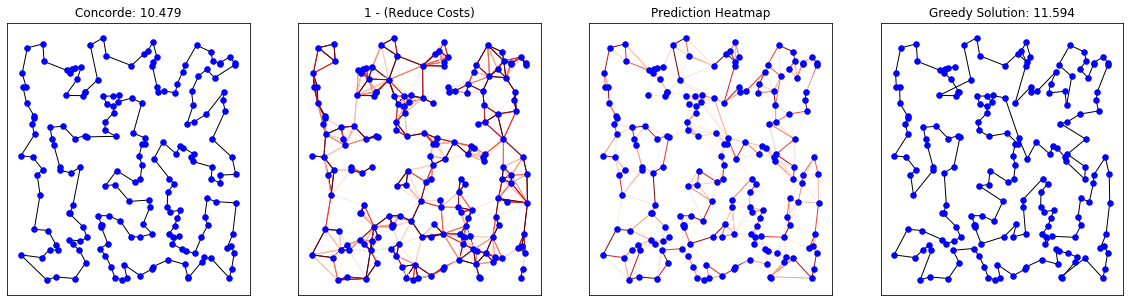

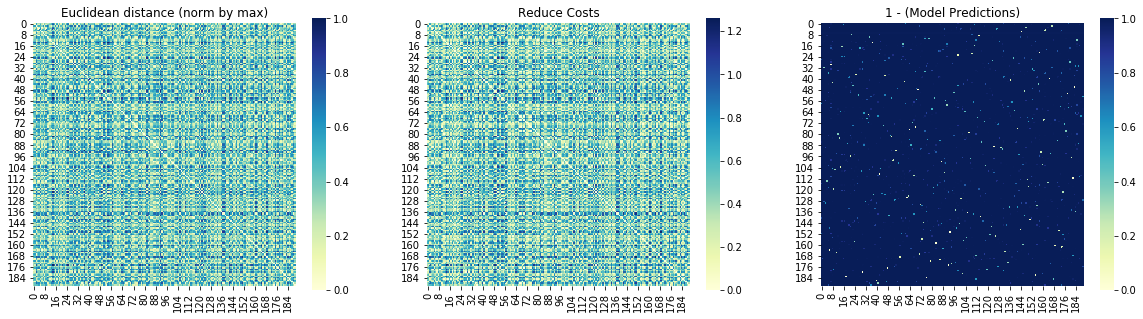

--------------------------------------------------------------------------------------------------------------------------------------------

TSP200



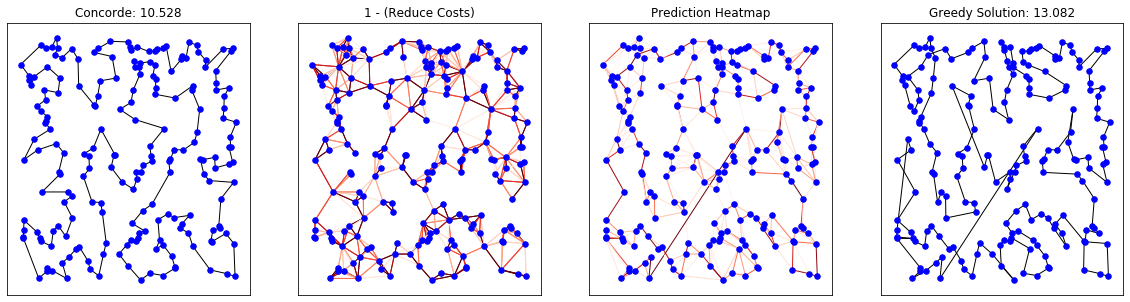

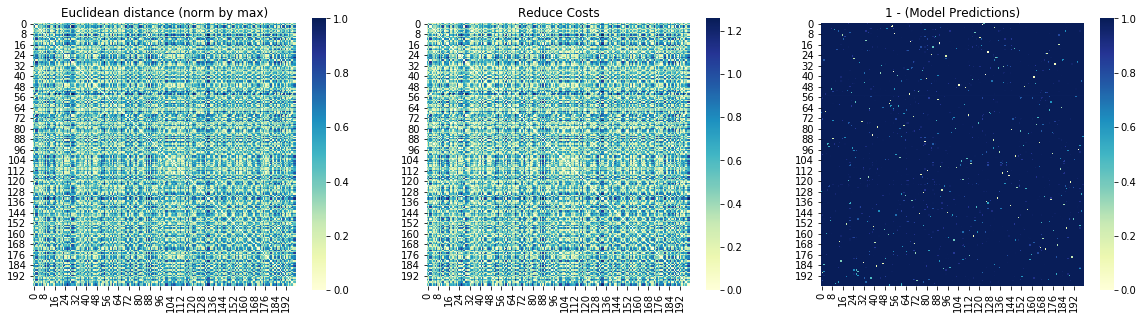

In [99]:
plot_idx = 1
prev_size = 0
with torch.no_grad():

    for bat_idx, bat in enumerate(dataloader):
        
        if bat['nodes'].shape[1] > prev_size:
            
            print("--------------------------------------------------------------------------------------------------------------------------------------------")
            print(f"\nTSP{bat['nodes'].shape[1]}\n")
            
            x = move_to(bat['nodes'], opts.device)
            graph = move_to(bat['graph'], opts.device)
            tour_nodes = move_to(bat['tour_nodes'], opts.device)

            cost, ll, pi = model(x, graph, return_pi=True)
            gt_cost, _ = TSP.get_costs(x, tour_nodes)
            
            f = plt.figure(0, figsize=(20, 5))
            
            p1 = f.add_subplot(141)
            plot_tsp(
                p1, 
                x[plot_idx].cpu().numpy(), 
                tour_nodes[plot_idx].cpu().numpy(), 
                title=f"Concorde: {gt_cost[plot_idx].cpu().numpy():.3f}"
            )
            
            p2 = f.add_subplot(142)
            plot_tsp_rcs(
                p2, 
                x[plot_idx].cpu().numpy(), 
                get_reduce_costs(x[plot_idx].cpu().numpy()), 
                threshold=0.05,
                title="1 - (Reduce Costs)"
            )
            
            p3 = f.add_subplot(143)
            plot_tsp_heatmap(
                p3, 
                x[plot_idx].cpu().numpy(), 
                log_p_to_heatmap(
                    np.exp(model.log_p_batch[plot_idx].cpu().numpy()), 
                    pi[plot_idx].cpu().numpy()
                ), 
                threshold=0.1,
                title="Prediction Heatmap"
            )
            
            p4 = f.add_subplot(144)
            plot_tsp(
                p4, 
                x[plot_idx].cpu().numpy(), 
                pi[plot_idx].cpu().numpy(), 
                title=f"Greedy Solution: {cost[plot_idx].cpu().numpy():.3f}"
            )
            
            plt.show()
            
            f = plt.figure(0, figsize=(20, 5))
            
            p1 = f.add_subplot(131)
            sns.heatmap(
                normalize_dists(
                    squareform(pdist(x[plot_idx].cpu().numpy(), metric='euclidean'))
                ),
                cmap="YlGnBu",
                ax=p1,
                square=True
            ).set_title("Euclidean distance (norm by max)")
            
            p2 = f.add_subplot(132)
            sns.heatmap(
                get_reduce_costs(x[plot_idx].cpu().numpy()),
                cmap="YlGnBu",
                ax=p2,
                square=True
            ).set_title("Reduce Costs")
            
            p3 = f.add_subplot(133)
            sns.heatmap(
                1 - log_p_to_heatmap(np.exp(model.log_p_batch[plot_idx].cpu().numpy()), pi[plot_idx].cpu().numpy()),
                cmap="YlGnBu",
                ax=p3,
                square=True
            ).set_title("1 - (Model Predictions)")
            
            plt.show()
            
        prev_size = bat['nodes'].shape[1]